In [316]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from math import sqrt, cos, radians

In [317]:
initial_data = pd.read_excel('data/initial_data.xlsx')

In [318]:
initial_data.drop('Unnamed: 0', axis=1, inplace=True)

In [319]:
initial_data['NEAR_metro_rjd'].fillna(0, inplace=True)

In [320]:
renamer = {np.nan:0, 'автостанция':1, 'остановка':1}
initial_data['NEAR_Stations'] = initial_data['NEAR_Stations'].map(renamer)

In [321]:
initial_data['Avg_check'] = initial_data['value1'] / initial_data['value2']

In [322]:
initial_data.describe()

,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Avg_check
count,72.000000,153.000000,72.000000,153.000000,140.000000,416.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,2.416667,1.362745,0.347222,7.156863,0.892857,2551.600962,10006.038369,2808.601918,147402.803357,0.103118,0.035971,0.023981,0.220624,404089.705036,3.579314
std,1.275445,0.899699,0.479428,3.509606,0.310405,1963.959893,57.084102,202.017409,175342.903452,0.304478,0.186442,0.153173,0.415165,17786.448797,0.233648
min,1.000000,0.200000,0.000000,1.000000,0.000000,0.000000,9911.000000,2231.000000,119.000000,0.000000,0.000000,0.000000,0.000000,387679.000000,2.898967
25%,2.000000,0.700000,0.000000,5.000000,1.000000,1001.500000,9956.000000,2670.000000,11288.000000,0.000000,0.000000,0.000000,0.000000,387679.000000,3.438011
50%,2.000000,1.200000,0.000000,7.000000,1.000000,2165.000000,9999.000000,2781.000000,55282.000000,0.000000,0.000000,0.000000,0.000000,387679.000000,3.593627
75%,3.000000,1.900000,1.000000,9.000000,1.000000,3558.750000,10056.000000,2928.000000,324698.000000,0.000000,0.000000,0.000000,0.000000,423321.000000,3.731360
max,7.000000,4.800000,1.000000,19.000000,1.000000,9775.000000,10100.000000,3484.000000,482873.000000,1.000000,1.000000,1.000000,1.000000,423321.000000,4.442403


In [323]:
initial_data['CITY'] = [w.lower() for w in initial_data['CITY']]

In [324]:
initial_data.head()

,ADDRESS,CITY,REGION,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Avg_check
0,"г.Калуга, Литейная ул., 25/15",калуга,Калужская область,NaN,3.3,NaN,13.0,1.0,7696.0,10099,3382,324698,0,0,0.0,1,423321,2.986103
1,"г.Калуга, Гагарина ул., 1",калуга,Калужская область,NaN,NaN,NaN,NaN,NaN,6369.0,10068,3236,324698,1,1,0.0,1,423321,3.111248
2,"г.Калуга, Кибальчича ул., 25",калуга,Калужская область,NaN,3.1,NaN,12.0,1.0,5553.0,10100,3436,324698,1,0,0.0,0,423321,2.939464
3,"г.Калуга, Пестеля ул., 60/49",калуга,Калужская область,3.0,2.2,0.0,12.0,1.0,7162.0,10099,3257,324698,0,0,0.0,0,423321,3.100706
4,"г.Калуга, Ленина ул., 81",калуга,Калужская область,1.0,2.0,0.0,9.0,1.0,6269.0,10096,3195,324698,1,0,0.0,1,423321,3.159937


In [325]:
with open('data/coords.json', 'r') as dt:
    coords = json.loads(dt.read())
corrupted_coords = []
for k, v in coords.items():
    v[0] = float(v[0])
    v[1] = float(v[1])
    if v[1] < 33.9 or v[1] > 39 or v[0] > 55.3 or v[0] < 53:
        corrupted_coords.append(k)
initial_data['coords'] = initial_data['ADDRESS'].copy()
initial_data['coords'] = initial_data['coords'].map(coords)

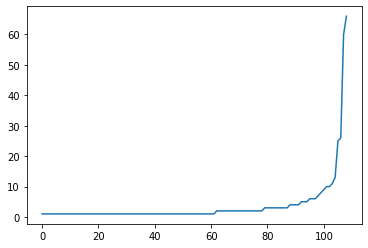

In [326]:
city_lens = sorted(dict(Counter(initial_data['CITY'])).values())
plt.plot(city_lens)

In [327]:
def havdist(lat1, lon1, lat2, lon2):
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    x = (lon2 - lon1) * cos(0.5 * (lat2 + lat1))
    y = lat2 - lat1
    return 6371 * sqrt(x**2 + y**2)

In [328]:
coords = list(coords.values())

In [329]:
for i in range(initial_data.shape[0]):
    point = initial_data.loc[i].coords
    closest = 10000000
    for n in coords:
        dist = havdist(point[0], point[1], n[0], n[1])
        if dist >= 0.01:
            if dist < closest:
                closest = dist
    initial_data.at[i, 'dist_to_closest'] = closest

In [330]:
for corr in corrupted_coords:
    initial_data = initial_data[initial_data.ADDRESS != corr]


---



In [332]:
correl_data = initial_data.drop(['ADDRESS', 'CITY', 'REGION'], axis=1)

In [333]:
correl_data.fillna(0, inplace=True)

In [334]:
correl_data.corr()

,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Avg_check,dist_to_closest
Postamat_daily,1.000000,0.173504,0.572135,0.135088,0.106227,0.327771,0.214368,0.305061,0.411798,0.148035,0.007348,-0.004007,0.134419,-0.021745,-0.300127,-0.120355
cashbox_daily,0.173504,1.000000,0.150100,0.928764,0.761569,0.351420,0.188124,0.309376,0.152088,0.145213,0.174063,-0.051235,0.142956,0.345002,-0.306592,-0.170533
Postamat_trend,0.572135,0.150100,1.000000,0.133803,0.118299,0.257758,0.118383,0.141384,0.278540,0.044399,0.058117,-0.041023,0.131746,0.005678,-0.145207,-0.078080
cashbox_MAX,0.135088,0.928764,0.133803,1.000000,0.827787,0.329400,0.136035,0.264655,0.108238,0.079351,0.068325,-0.051179,0.127980,0.331189,-0.266652,-0.176682
cashbox_trend,0.106227,0.761569,0.118299,0.827787,1.000000,0.274831,0.128669,0.231139,0.051389,0.030810,-0.017477,-0.071782,0.077152,0.299999,-0.235785,-0.167665
hh_500,0.327771,0.351420,0.257758,0.329400,0.274831,1.000000,0.189069,0.442810,0.512760,0.217512,0.207117,-0.055885,0.230564,-0.072475,-0.450451,-0.311243
value1,0.214368,0.188124,0.118383,0.136035,0.128669,0.189069,1.000000,0.858866,0.047314,0.143954,0.040493,-0.100796,0.074068,0.209293,-0.841464,-0.005431
value2,0.305061,0.309376,0.141384,0.264655,0.231139,0.442810,0.858866,1.000000,0.220766,0.283870,0.106302,-0.041338,0.216236,0.083692,-0.994439,-0.162804
POPULATION,0.411798,0.152088,0.278540,0.108238,0.051389,0.512760,0.047314,0.220766,1.000000,0.236044,0.142939,0.009042,0.418850,-0.095437,-0.222709,-0.246941
NEAR_Malls,0.148035,0.145213,0.044399,0.079351,0.030810,0.217512,0.143954,0.283870,0.236044,1.000000,0.186794,-0.003462,0.236257,-0.083207,-0.281149,-0.096498


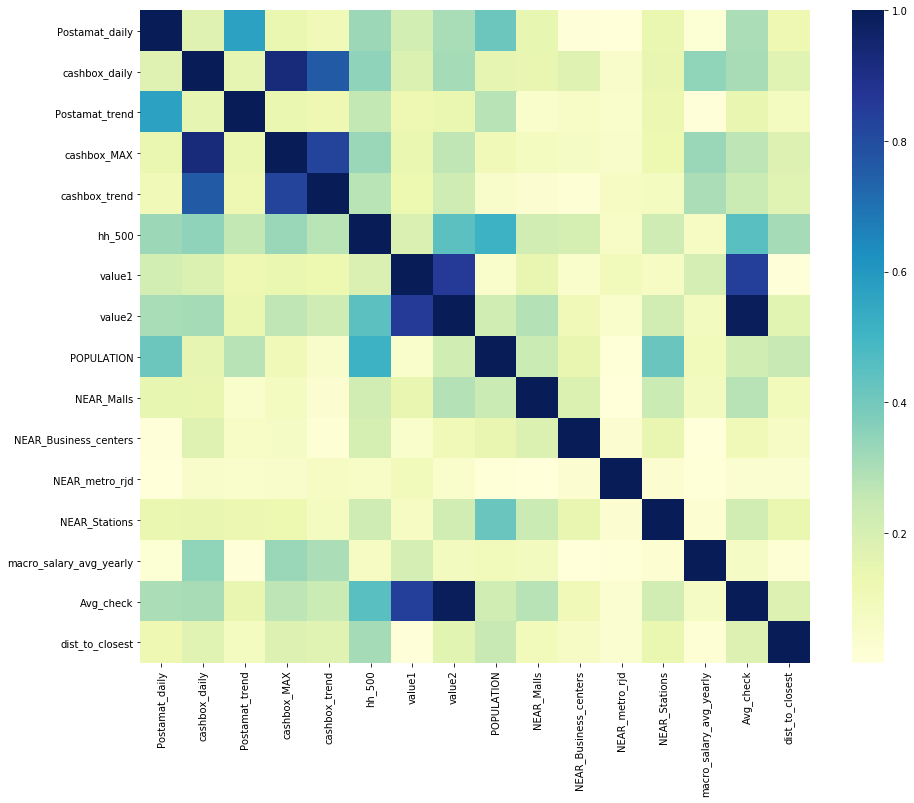

In [335]:
fig = plt.figure(figsize=(15, 12)) 
ax = plt.subplot()
ax = sns.heatmap(abs(correl_data.corr()), cmap="YlGnBu")